24/08/04 09:33:42 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Timestamp, MTO_13-FI-11415.PV, MTO_13-PIC-12105.PV, MTO_13-TI-12103.PV, MTO_13-FI-12101.PV, MTO_13-FI-12101-H.PV, MTO_13-FI-12102.PV, MTO_13-FI-12102-H.PV, MTO_13-FI-12112.PV, MTO_13-FI-12112-H.PV, MTO_13-FI-12129.PV, MTO_13-FI-12129-H.PV, MTO_13-FIC-12102.PV, MTO_13-FIC-12112.PV, MTO_13-FIC-12129.PV, MTO_13-PI-12101.PV, MTO_13-PI-12102.PV, MTO_13-PI-12106.PV, MTO_13-PI-12112.PV, MTO_13-PI-12117.PV, MTO_13-PI-12128.PV, MTO_13-PI-12129.PV, MTO_13-TI-12101.PV, MTO_13-TI-12102.PV, MTO_13-TI-12105.PV, MTO_13-TI-12112.PV, MTO_13-TI-12113.PV, MTO_13-TI-12129.PV, MTO_13-TI-12130.PV, MTO_13-PI-12670.PV, MTO_13-PIA-12630.PV, MTO_13-PISA-12642.PV, MTO_13-PISA-12671.PV, MTO_13-SI-12631A.PV, MTO_13-FI-12661.PV, MTO_13-FI-12662.PV, MTO_13-FIA-12663.PV, MTO_13-FIA-12664.PV, MTO_13-FIA-12695.PV, MTO_13-FIA-12696.PV, MTO_13-FIA-12697.PV, MTO_13-FIA-12698.PV, MTO_13-FINSA-12660.PV, MTO_13-FINSA-12665.PV, MTO_13

+---------------+------------------+-------------------+------------------+------------------+--------------------+------------------+--------------------+------------------+--------------------+------------------+--------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+----------------------+--------------------+---------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+---------------------+---------------------+---------------------+---------------------+-------------------+-------------------+-------------------+-------------------+--------

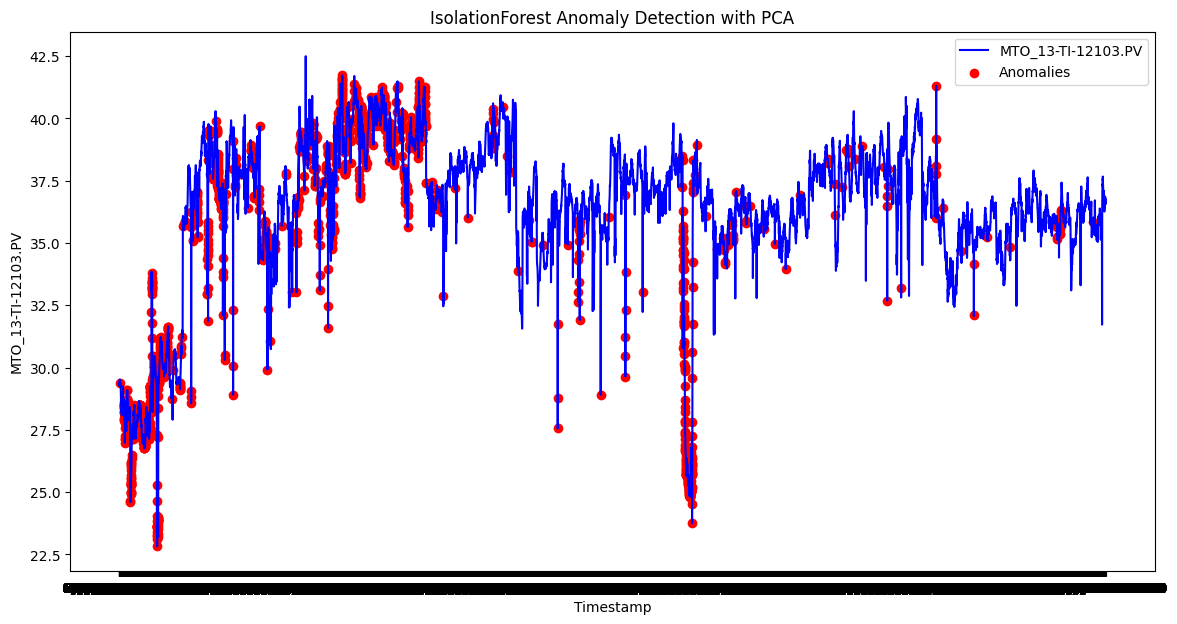

In [9]:
from pyspark.sql import SparkSession
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Tạo Spark session
spark = SparkSession.builder.appName("AnomalyDetection").getOrCreate()

# Đọc file CSV
df = spark.read.csv("../../../data/Compressor_2022_June-Oct.csv", header=True, inferSchema=True)
# Hiển thị dữ liệu
df.show()

# Chuyển đổi DataFrame của Spark thành Pandas DataFrame
pandas_df = df.toPandas()

# Lấy danh sách header và bỏ qua cột đầu tiên
columns = df.columns

# Chọn cột đầu tiên làm trục X (Timestamp) và một cột được chọn làm trục Y
timestamp_column = columns[0]
selected_column = columns[3]  # Thay thế bằng tên cột bạn muốn chọn làm trục Y

# Hàm xử lý dữ liệu thiếu
def handle_missing_data(df, method="mean_fill"):
    if method == "backward_fill":
        df = df.fillna(method='bfill')
    elif method == "forward_fill":
        df = df.fillna(method='ffill')
    elif method == "mean_fill":
        df = df.fillna(df.mean())
    # Nếu là "no-cleaning", không làm gì cả
    return df

# Áp dụng phương pháp xử lý mean fill
pandas_df.iloc[:, 1:] = handle_missing_data(pandas_df.iloc[:, 1:], "mean_fill")

# Hiển thị dữ liệu sau khi xử lý
print("Dữ liệu sau khi xử lý mean fill:")
print(pandas_df)

# Chọn các cột cần thiết cho mô hình IsolationForest (bỏ qua cột đầu tiên)
features = pandas_df[columns[1:]].values

# Áp dụng PCA để giảm số lượng đặc trưng
pca = PCA(n_components=2)  # Thay đổi số lượng thành phần chính nếu cần
features_pca = pca.fit_transform(features)

# Sử dụng IsolationForest để phát hiện bất thường
model = IsolationForest(contamination=0.1)  # Đặt mức độ bất thường mong muốn
model.fit(features_pca)

# Dự đoán các điểm bất thường
predictions = model.predict(features_pca)

# Thêm cột dự đoán vào DataFrame
pandas_df["anomaly"] = predictions

# Vẽ biểu đồ line với trục X là Timestamp và trục Y là selected_column, các điểm bất thường được đánh dấu bằng scatter màu đỏ
plt.figure(figsize=(14, 7))

# Vẽ biểu đồ line cho cột được chọn
plt.plot(pandas_df[timestamp_column], pandas_df[selected_column], label=selected_column, color='blue')

# Vẽ các điểm bất thường bằng scatter màu đỏ
anomalies = pandas_df[pandas_df["anomaly"] == -1]
plt.scatter(anomalies[timestamp_column], anomalies[selected_column], color='red', label="Anomalies")

plt.xlabel(timestamp_column)
plt.ylabel(selected_column)
plt.legend()
plt.title("IsolationForest Anomaly Detection with PCA")
plt.show()
